# Fitting is an Art!

### Description
Python macro for testing which fitting procedure is likely to give the "best" results. The two cases in question are:
   * Gaussian distribution(s?) on constant background (peak searching)
   * Double exponential distribution (high correlations)

### Your Task
Consider each case and argue/discuss which fitting function and method should be used.

***
### Authors:
- Troels Petersen ([email](mailto:petersen@nbi.dk))

### Last update:
- 6th of January 2021

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy import stats
import os, sys                                         # Modules to see files and folders in directories
from os.path import dirname as parent_folder

In [2]:
sys.path.append('../../../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

In [3]:
# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)

In [4]:
SavePlots = False         # Determining if plots are saved or not

In [5]:
pi = np.pi
r = np.random                         # Random generator
r.seed(41)                            # Set a random seed (but a fixed one - more on that later.)

---
## CASE 1: Gaussian distribution on a constant background:

The initial fitting function is the following:

* $f_{1}(x) = C+ \frac{N}{\sigma\sqrt(2\pi)}\cdot \exp \left[-0.5 \cdot\left(\frac{(x-\mu)}{\sigma}\right)^{2} \right]$ for $x$ in $[-\infty,\infty]$

It disregards both the "outliers" in the main peak, and perhaps also something else at higher values. Your job is to expand the fit until it really describes the data.

In [6]:
Npoints_gauss = 400
mux    = 3.50
sigmax = 0.25

Npoints_pol0 = 2000
minx   =  0.0
maxx   = 10.0
Nbins = 100
binwidth_gauss = (maxx-minx) / float(Nbins)
print(f"  The bin width is: {binwidth_gauss:5.2f}")

  The bin width is:  0.10


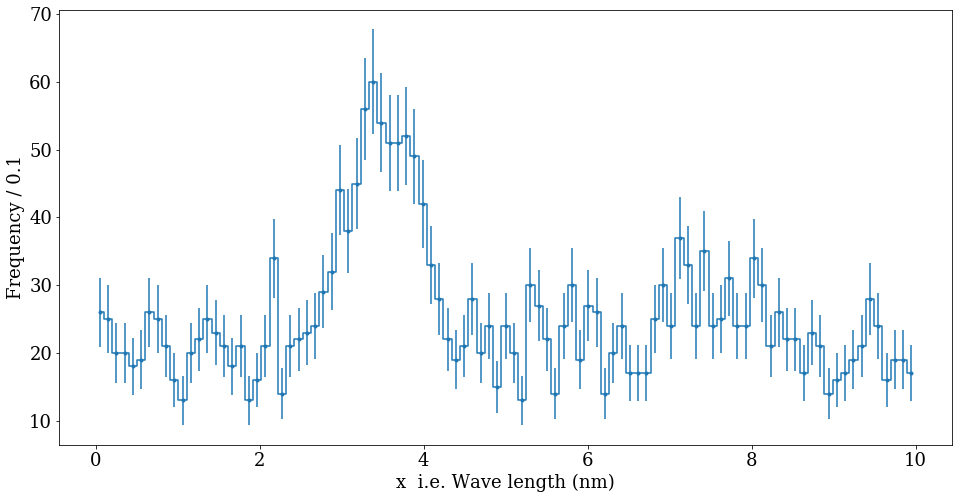

In [7]:
# Fill histogram with signal and background events:

signal = np.random.normal(loc=mux,scale=sigmax,size=Npoints_gauss)
signal_2=np.random.normal(loc=mux+4.1,scale=sigmax,size=int(Npoints_gauss/3.14))

bkg = np.random.uniform(low=minx,high=maxx,size=Npoints_pol0)

Y = np.concatenate([signal,bkg,signal_2])
binning = np.linspace(minx,maxx,Nbins)

counts,bin_edges = np.histogram(Y,bins=binning)
unc_count = np.sqrt(counts)
X = bin_edges[:-1]+(bin_edges[1]-bin_edges[0])/2.

fig, ax = plt.subplots(figsize=(16, 8))
ax.errorbar(X, counts, yerr=unc_count, marker = '.', drawstyle = 'steps-mid')
ax.set_xlabel('x  i.e. Wave length (nm)', fontsize=18)
ax.set_ylabel('Frequency / 0.1', fontsize=18);

### Define function (including bin width to get normalisation right):


In [8]:
def func_gpol0(x,a,mu,sigma,cst) :
    norm = binwidth_gauss * a / np.sqrt(2.0*pi) / sigma
    z = (x-mu)/sigma
    return norm * np.exp(-0.5*z*z) + cst

In [9]:
select = counts>0
chi2reg = Chi2Regression(func_gpol0, X[select], counts[select], unc_count[select])
minuit_obj = Minuit(chi2reg, pedantic=False, print_level=0, a=1.0, mu=1.0, sigma=1.0)
minuit_obj.migrad()   

if (not minuit_obj.fmin.is_valid) :                                   # Check if the fit converged
    print("  WARNING: The ChiSquare fit DID NOT converge!!!")

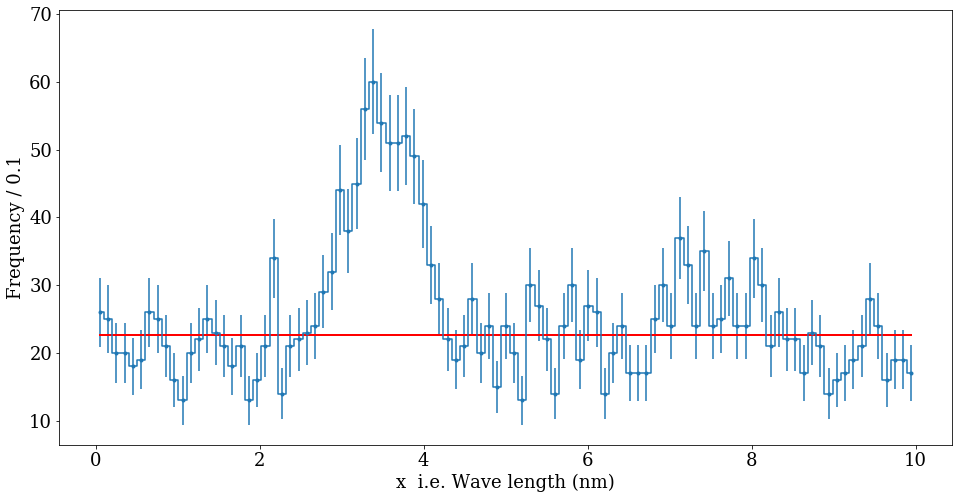

In [10]:
bf_a, bf_mu, bf_sigma, bf_cst = minuit_obj.args
ax.plot(X,func_gpol0(X, bf_a, bf_mu, bf_sigma, bf_cst), 'r', linewidth=2.0, label='Const + Gauss fit')
fig

---

Look at the first case, but make sure that you also do the second case (see below), as this is
at least as important as the first one!

Questions on CASE 1:
--------------------
 1. Look at the data plot and the corresponding fit. What type of fit is it? Does it
    run well (or at all)? And once it runs, does it seem to be reasonable? Why/why not?
    And does the fitting function include all features of the data? Why/why not? Try for
    5-10 minutes and discuss it with others (if possible), before reading on!

---
_5-10 minutes later_...

---

 2. What is the p-value from the minimal Chi2 that your fit obtained? Is it acceptable?

---
_5-10 minutes later_...

---

 3. As it happens, there are tails on the main peak, and there also seem to be a
    suspectable bump around 7 < x < 8. Try to write
    an expanded fitting function, which includes this bump in the model, and get the
    fit to run. How significant is the bump, based on significance of the amplitude of
    the second Gaussian peak? And what test would you apply to this, if you wanted to
    make a full-fledged hypothesis test between the two models? Are they nested? Can
    you actually get a number out?

---
_10-20 minutes later_...

---

 4. Imagine that you concluded that there was a new peak, and that you were sure that
    it had the same width as the original peak (for example because the width was due to
    the resolution of the apperatus, and not the peak itself). Does that help you in the fit,
    and if so, how? Does the significance of the peak increase? Would it always do that?
    Also imagine, that the parameter of interest is the distance between the peaks. How
    would you now write your fitting function?
    

## NOTE: 

If one wanted to test the G+pol0 vs. the G+G+pol0 models against each other, which might be relevant, then a likelihood ratio test would be obvious, and Wilk's theorem would provide the way to produce a p-value, thus doing a proper hypothesis test:

* Using iminuit and the `UnbinnedLH` function instead of the $\chi^{2}$ regression, you can minimize the data again
* You can minimize both cases, and save the value of the LLH using `minuit_obj.fval`.
* After that, you can compute the test statistic $-2\log{\frac{LH_{1}}{LH_{2}}}$, and see that it is $\chi^{2}$ distributed (Wilk's Theorem).

The test statistic distribution will have $N_{dof} = 3$, unless you (smartly) eliminated one parameter from the second fit.

---
---

## CASE 2: Double exponential distribution

Here we are considering the fitting of exponential data, and how the writing of the fitting function is important.

* The "bad" fitting function:
    $f_{2,bad}(t)  = N_{1}\cdot\exp(-t/r_{1}) + N_{2}\cdot\exp(-t/r_{2})$ for $t$ in $[0,\infty]$

* The "good" fitting function:
    $f_{2,good}(t) = N \cdot\left(\frac{f}{r_{1}}\cdot \exp\left[-t/r_{1}\right] + \frac{(1-f)}{r_{2}}\cdot\exp\left[-t/r_{2}\right]\right)$ for $t$ in $[0,\infty]$

## NOTE
The parameters $r_1$ and $r_2$ need to be positive, and $f$ in [0,1], in order for this to be a PDF.

---

In [11]:
Npoints_2exp = 2000
frac = 0.5   # Fraction that "belongs to" first exponential
r1 = 10.0
r2 =  2.0     # Note that the two lifetimes are not very different!
nbins_2exp = 200
xmin_2exp = 0.0
xmax_2exp = 20.0
binning = np.linspace(xmin_2exp, xmax_2exp, nbins_2exp)
binwidth_2exp = (xmax_2exp - xmin_2exp) / nbins_2exp
print(binwidth_2exp)

0.1


In [12]:
all_pts = np.random.uniform(size=Npoints_2exp) 
N1 = sum(all_pts<frac)

t = np.concatenate([np.random.exponential(scale=r1, size=N1),
                    np.random.exponential(scale=r2, size=(Npoints_2exp-N1))])

counts,bin_edges = np.histogram(t,bins=binning)
unc_2exp = np.sqrt(counts)

Text(0, 0.5, 'count')

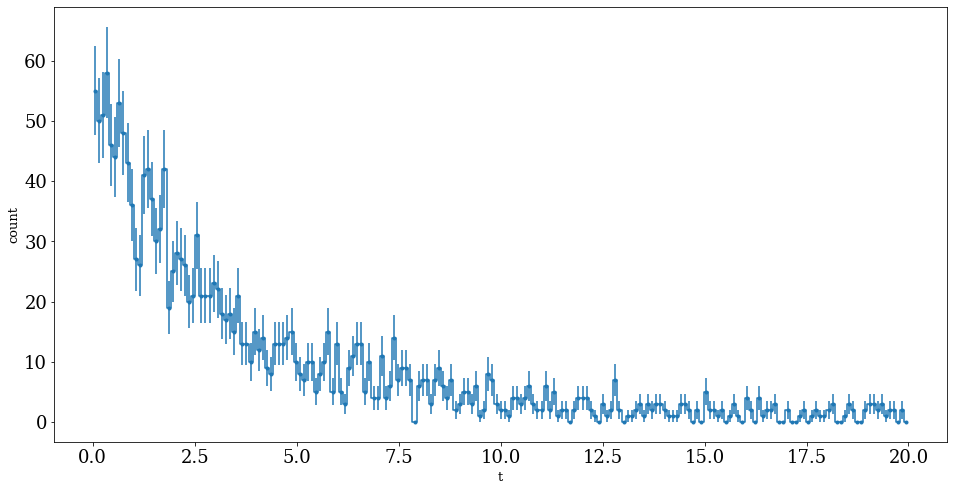

In [13]:
X = bin_edges[:-1]+(bin_edges[1]-bin_edges[0])/2.

fig, ax = plt.subplots(figsize=(16, 8))
ax.errorbar(X,counts,yerr=unc_2exp,marker = '.',drawstyle = 'steps-mid')
ax.set_xlabel('t',fontsize=13)
ax.set_ylabel('count',fontsize=13)

### Let's try to fit the data with the bad model:
I include the binwidth (here 0.1) in the fit to ensure that the normalisations are (or could be) right!

In [14]:
def f_2expBad(x,N1,r1,N2,r2):
    binwidth = binwidth_2exp
    return binwidth*(N1*np.exp(-x/r1)+N2*np.exp(-x/r2))

In [15]:
select = counts>0
chi2reg = Chi2Regression(f_2expBad, X[select], counts[select], unc_2exp[select])

#the bad fit:
minuit_obj = Minuit(chi2reg, pedantic=False, print_level=1, N1=frac*Npoints_2exp, r1=r1, N2=(1-frac)*Npoints_2exp, r2=r2)
minuit_obj.migrad()

if (not minuit_obj.fmin.is_valid) :                                   # Check if the fit converged
    print("  WARNING: The ChiSquare fit DID NOT converge!!!")

------------------------------------------------------------------
| FCN = 212.9                   |     Ncalls=214 (214 total)     |
| EDM = 0.000143 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------


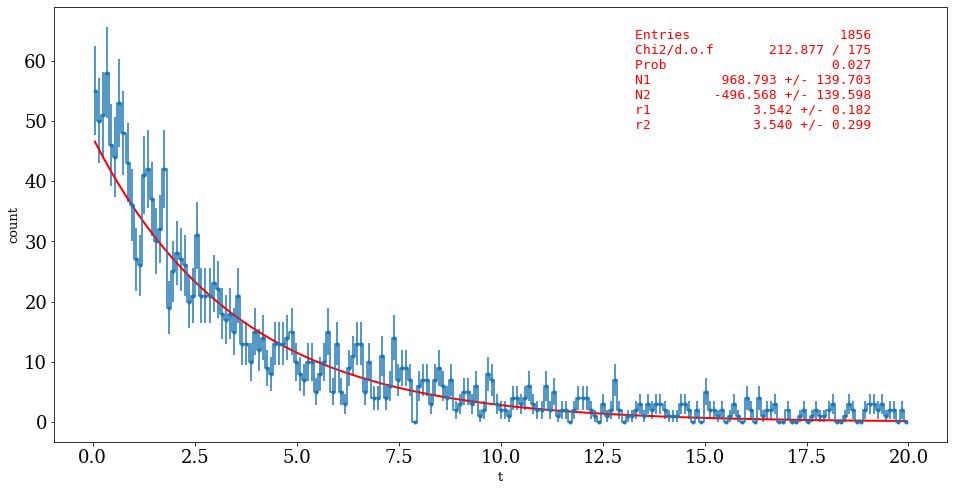

In [16]:
bf_N1,bf_r1,bf_N2,bf_r2 = minuit_obj.args
Chi2 = minuit_obj.fval
Ndof = len(X[select])-len(minuit_obj.args)
ProbChi2 = stats.chi2.sf(Chi2, Ndof)

ax.plot(X, f_2expBad(X,bf_N1,bf_r1,bf_N2,bf_r2), 'r', linewidth=2.0, label='Bad fitting function')

d = {'Entries'   : "{:d}".format(sum(counts)),
     'Chi2/d.o.f': "{:.3f} / {:d}".format(Chi2, Ndof),
     'Prob'      : "{:.3f}".format(ProbChi2),
     'N1'        : "{:.3f} +/- {:.3f}".format(minuit_obj.values['N1'], minuit_obj.errors['N1']),
     'N2'        : "{:.3f} +/- {:.3f}".format(minuit_obj.values['N2'], minuit_obj.errors['N2']),
     'r1'        : "{:.3f} +/- {:.3f}".format(minuit_obj.values['r1'], minuit_obj.errors['r1']),
     'r2'        : "{:.3f} +/- {:.3f}".format(minuit_obj.values['r2'], minuit_obj.errors['r2'])}

ax.text(0.65, 0.95, nice_string_output(d, 0), family='monospace', 
        transform=ax.transAxes, fontsize=13, color='red', verticalalignment='top')
fig

In [17]:
# Given the covariance matrix, we calculate and print the correlation matrix:
corrBad={}                                       # Define an empty dictionary (the correlation matrix)
for k,v in minuit_obj.covariance.items() :       # k=key (i.e. index by which you look up), v=value (well, value!)
    error1 = minuit_obj.errors[k[0]]       # The error object of minuit is the square root of the variance (ie. sigma)
    error2 = minuit_obj.errors[k[1]]
    correlation = v / float((error1*error2)) 
    print(k,correlation)
    corrBad[k] = correlation
    

('N1', 'N1') 1.0000000000000002
('N1', 'r1') -0.042377232642779886
('N1', 'N2') -0.9904393257822472
('N1', 'r2') -0.025054100833637644
('r1', 'N1') -0.042377232642779886
('r1', 'r1') 1.0
('r1', 'N2') -0.02419827526799987
('r1', 'r2') 0.9517074615915235
('N2', 'N1') -0.9904393257822472
('N2', 'r1') -0.02419827526799987
('N2', 'N2') 0.9999999999999998
('N2', 'r2') -0.011308944614162004
('r2', 'N1') -0.025054100833637644
('r2', 'r1') 0.9517074615915235
('r2', 'N2') -0.011308944614162004
('r2', 'r2') 1.0


In [18]:
# Convert dictionary to numpy array:
def print_correlation_matrix(d, params):
    
    ncols = int(np.sqrt(len(d.keys())))
    nrows = int(ncols)
    matrix = np.zeros(shape=[nrows,ncols])
    
    index = {}
    i=0
    for p in params:
        index[p]=i
        i+=1

    for k,v in d.items():
        l = index[k[0]]
        c = index[k[1]]
        matrix[l,c] = v
    return matrix

M = print_correlation_matrix(corrBad, ['N1','N2','r1','r2'])

from IPython.display import HTML, display
import pandas as pd
M = pd.DataFrame(M, columns=['N1','N2','r1','r2'], index=['N1','N2','r1','r2'])
display(M)

,N1,N2,r1,r2
N1,1.000000,-0.990439,-0.042377,-0.025054
N2,-0.990439,1.000000,-0.024198,-0.011309
r1,-0.042377,-0.024198,1.000000,0.951707
r2,-0.025054,-0.011309,0.951707,1.000000


Questions on CASE 2:
--------------------
 1. Does the "bad" fit work well? Does it extract the parameters used to produce it?
    Can you see what is missing? There are in fact several things, but one is simple to remedy.
    Think and discuss...
   
---
_5-10 minutes later_...

---
Of course you need to give the fit good initial values! Do this (for example those the data was produced with!), and run it again. It might work now, but actually that is not always the case. The reason is that the "bad" fitting function has two flaws:

* It does not have a correct normalisation, thus making N1 and N2 correlated, as well as r1 and r2.
* It does not have one overall normalisation, thus making N1 and N2 correlated.

This gives very high correlations between the parameters, as can be seen from the correlation matrix printed.

 2. Both of these problems can be avoided by rewriting the fitting function to include
    the correct normalisation (i.e. dividing by the lifetime) and by putting only one
    overall normalisation and then dividing the two lifetimes with a fraction (i.e. use
    "frac" and "(1.0-frac)" as a parameter in front of each exponential term).
    Try this (define a "good" function), and see if your fit improves. The way to see
    this would in general be to try a lot of different data, but here we will simply see
    that the correlations are smaller (especially for the overall normalisation).
---
_10-20 minutes later_...

---  

__If you didn't manage to get this fit going, I've included a "good" fitting function below! (but try yourself first!)__

 3. The two lifetimes are naturally very correlated with each other (and the fraction),
    when they are very alike. The only thing one can do about this is to fix one parameter.
    This is of course not desirable, but one can be forced to do it, if the fit does not
    converge otherwise. Note that since the correlation is very high, it is not a great
    loss of freedom in the fitting function.
    
    A very common similar example is fitting a "Gaussian-like" peak, which happens to have
    more than one width, for example if the data is obtained from two or more sources with
    different resolutions (as above). Here, one may choose to let the two (or more) Gaussians have
    the same mean, but two different widths (the "good" and the "bad" measurements).
    Typically, the parameter to fix (if any) is the fraction, but never fix a parameter
    without first having tried to let it "float".

### The GOOD fitting function and fit:

In [19]:
def good_exp(x,N,f,r1,r2):
    binwidth = binwidth_2exp
    # f = fraction
    return binwidth*N*(f/r1*np.exp(-x/r1)+(1-f)/r2*np.exp(-x/r2))

In [20]:
select = counts>0
chi2reg = Chi2Regression(good_exp, X[select], counts[select], unc_2exp[select])
minuit_obj = Minuit(chi2reg, pedantic=False, print_level=1, N=Npoints_2exp, r1=r1, r2=r2, f=frac)
minuit_obj.migrad()

if (not minuit_obj.get_fmin().is_valid) :                                   # Check if the fit converged
    print("  WARNING: The ChiSquare fit DID NOT converge!!!")

bf_N,bf_f,bf_r1,bf_r2 = minuit_obj.args
Chi2 = minuit_obj.fval
Ndof = len(X[select])-len(minuit_obj.args)
ProbChi2 = stats.chi2.sf(Chi2, Ndof)
print(ProbChi2)

------------------------------------------------------------------
| FCN = 152.8                   |     Ncalls=683 (683 total)     |
| EDM = 0.000276 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   False   |        True        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
0.8857153961970435


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: get_fmin is deprecated: use `this_object.fmin` instead
  


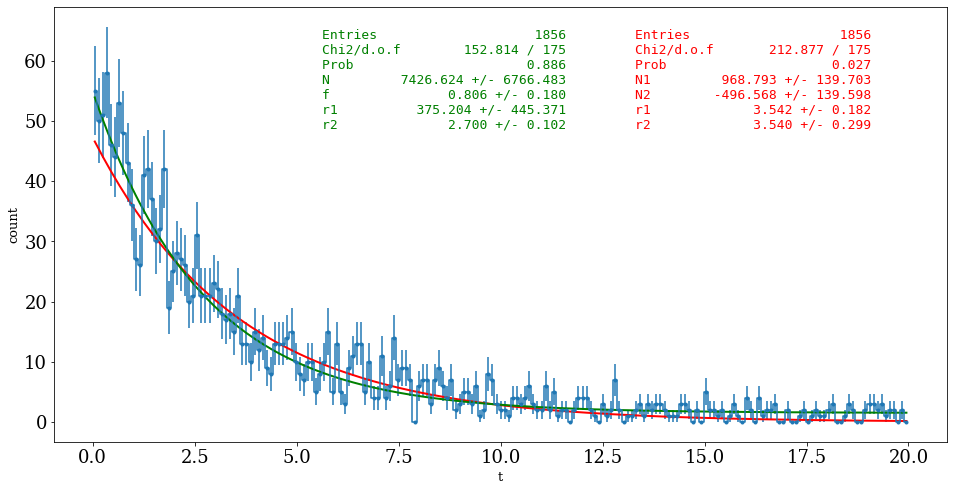

In [21]:
ax.plot(X,good_exp(X,bf_N,bf_f,bf_r1,bf_r2),'g',linewidth=2.0,label='Good-fit')

d = {'Entries'   : "{:d}".format(sum(counts)),
     'Chi2/d.o.f': "{:.3f} / {:d}".format(Chi2, Ndof),
     'Prob'      : "{:.3f}".format(ProbChi2),
     'N'         : "{:.3f} +/- {:.3f}".format(minuit_obj.values['N'], minuit_obj.errors['N']),
     'f'         : "{:.3f} +/- {:.3f}".format(minuit_obj.values['f'], minuit_obj.errors['f']),
     'r1'        : "{:.3f} +/- {:.3f}".format(minuit_obj.values['r1'], minuit_obj.errors['r1']),
     'r2'        : "{:.3f} +/- {:.3f}".format(minuit_obj.values['r2'], minuit_obj.errors['r2'])}

ax.text(0.3, 0.95, nice_string_output(d, 0), family='monospace', 
        transform=ax.transAxes, fontsize=13, color='green', verticalalignment='top')
fig

In [22]:
# We calculate the correlation matrix as in the Bad fit case:
corrGood={}
for k,v in minuit_obj.covariance.items() :       
    error1 = minuit_obj.errors[k[0]]       
    error2 = minuit_obj.errors[k[1]]
    correlation = v / float((error1*error2)) 
    corrGood[k] = correlation


M = print_correlation_matrix(corrGood,['N','f','r1','r2'])
M = pd.DataFrame(M, columns=['N','f','r1','r2'],index=['N','f','r1','r2'])
display(M)

,N,f,r1,r2
N,1.000000,0.999801,0.999977,0.246152
f,0.999801,1.000000,0.999746,0.234786
r1,0.999977,0.999746,1.000000,0.247965
r2,0.246152,0.234786,0.247965,1.000000
